<a href="https://colab.research.google.com/github/HillaAnku/HillaAnku/blob/master/Property_Value_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

The model here aims to estimate the value of real estate property in the Louisville metro and surrounding areas in the state of Kentucky. The model is helpful to property investors in selecting properties and making purchase decisions. It is also particularly helpful to inexperienced home buyers and inexperienced investors in making property purchase decisions. This notebook walks through the data exploration, feature selection, construction and parameter tuning of my real estate property valuation model.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mpl_toolkits
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# io.parsers is used here to import zipcodes as strings

df = pd.io.parsers.read_csv('/content/drive/My Drive/python_for_data_scientists/real_estate.csv', dtype={'zipcode': 'str'})

In [0]:
# display all the columns of the dataset

pd.options.display.max_columns = None

In [0]:
df.head()

,Price,Beds,Baths,Area(sqft),Address,zipcode,Type,Untrimed,Year Built,Year Sold (Latest Sale),Age(Years),TotalRooms,LotSize(Acres),ParkingSpaces,NumofStories,HasGarage,TrimMat,ExteriorMat,HasBasement,HasPatio,HasPorch,HasDeck,HasLawn,HasPool,HasGarden,HasFireplace,CableReady,HasSecuritySystem,HasTennisCourt,HasIntercom
0,295500,2,1,1696,11120 Brookstone Ct,40223,Single Family,Single Family,1985,2020.0,35.0,7,0.3,0,1,Garage,Brick&Vinyl,Brick&Vinyl,,,Porch,NaN,,,,,,NaN,,
1,170900,1,1,1058,5404 Hasbrook Dr,40229,Single Family,Single Family,1978,2020.0,42.0,,,0,,Garage,NaN,,,Patio,Porch,Deck,,,,,,,,
2,236000,1,1,1734,1112 Lydia St,40217,Single Family,Single Family,1900,2020.0,120.0,8,,0,1,Garage,Vinyl,Vinyl,,,Porch,Deck,NaN,,,,,NaN,,
3,385000,3,2,2835,8601 Glenfield Way,40241,Single Family,Single Family,1999,2020.0,21.0,5,0.36,0,2,Garage,NaN,,,Patio,Porch,Deck,,,,,,NaN,,
4,354500,2,2,2310,516 Foxwick Ct,40223,Single Family,Single Family,1990,2020.0,30.0,,,0,,,Brick,Brick,,Patio,,,,,,,,NaN,,


The data was crawled from real estate listing websites, as such, the data is very unclean. There are leading and trailing spaces, there are unwanted characters in certain cases, data types for the columns are incorrect in many cases and there are quite a good number of missing values. I proceed by cleaning the data. The following lines use regular expressions to remove empty white spaces, unwanted characters and change the number type of incorrectly assigned columns.

In [0]:
df['Beds'] = df['Beds'].replace(r'^\s*[—]*\s*$', np.nan, regex=True)
df['Beds']= df['Beds'].apply('float64')
df['Beds']= df['Beds'].apply('int64')
df['Baths'] = df['Baths'].replace(r'^\s*[—]*[--]*\s*$', np.nan, regex=True)
df['Baths']= df['Baths'].apply('float64')
df['Area(sqft)'] = df['Area(sqft)'].replace(r'^\s*[—]*[--]*\s*$', np.nan, regex=True)
df['Area(sqft)']= df['Area(sqft)'].apply('float64')
df['Area(sqft)']= df['Area(sqft)'].apply('int64')
df['Age(Years)'] = df['Age(Years)'].replace(r'^\s*[—]*\s*$', np.nan, regex=True)
df['Age(Years)']= df['Age(Years)'].apply('float64')
df['Age(Years)']= df['Age(Years)'].apply('int64')
df['TotalRooms'] = df['TotalRooms'].replace(r'^\s*[—]*\s*$', np.nan, regex=True)
df['TotalRooms']= df['TotalRooms'].apply('float64')
df['TotalRooms']= df['TotalRooms'].apply('int64')
df['LotSize(Acres)'] = df['LotSize(Acres)'].replace(r'^\s*[—]*\s*$', np.nan, regex=True)
df['LotSize(Acres)']= df['LotSize(Acres)'].apply('float64')
df['ParkingSpaces'] = df['ParkingSpaces'].replace(r'^\s*[—]*\s*$', np.nan, regex=True)
df['ParkingSpaces']= df['ParkingSpaces'].apply('float64')
df['ParkingSpaces']= df['ParkingSpaces'].apply('int64')
df['NumofStories'] = df['NumofStories'].replace(r'^\s*[—]*\s*$', np.nan, regex=True)
df['NumofStories']= df['NumofStories'].apply('float64')

In [0]:
pd.options.display.max_rows = None

In [0]:
# Drop some unwanted columns

df = df.drop(['Year Built', 'Year Sold (Latest Sale)', 'Untrimed', 'ExteriorMat'], axis = 1)

In [0]:
# Since multiple and different listing websites were crawled, there may be cross listing of properties which may create duplication in the data.
# I drop duplicates based on property addresses

df.drop_duplicates(subset = "Address", keep = "first", inplace = True)

At this point, the data is fairly clean. I now begin to explore the data and also clean up alongside when the need arises.

In [0]:
# Quick view summary statistics of numerical columns

df.describe()

,Price,Beds,Baths,Area(sqft),Age(Years),TotalRooms,LotSize(Acres),ParkingSpaces,NumofStories
count,3.653000e+03,3.653000e+03,3556.000000,3.653000e+03,3.653000e+03,3.653000e+03,2843.000000,3.653000e+03,585.000000
mean,2.223319e+05,-2.272388e+17,2.192070,-1.615921e+17,-3.661070e+17,-8.152825e+18,0.569719,-2.706667e+18,1.114530
std,1.566757e+05,1.429976e+18,1.054335,1.210253e+18,1.800998e+18,2.954721e+18,6.743592,4.200402e+18,0.620465
min,7.500000e+02,-9.223372e+18,1.000000,-9.223372e+18,-9.223372e+18,-9.223372e+18,0.010000,-9.223372e+18,0.000000
25%,1.345000e+05,3.000000e+00,1.000000,1.165000e+03,2.200000e+01,-9.223372e+18,0.160000,-9.223372e+18,1.000000
50%,1.880000e+05,3.000000e+00,2.000000,1.621000e+03,5.000000e+01,-9.223372e+18,0.210000,1.000000e+00,1.000000
75%,2.740000e+05,3.000000e+00,3.000000,2.273000e+03,6.600000e+01,-9.223372e+18,0.280000,2.000000e+00,1.500000
max,2.700000e+06,7.000000e+00,9.000000,1.316000e+04,2.020000e+03,1.700000e+01,226.100000,2.100000e+01,3.000000


In the regex expression, np.nan is replacing empty/missing entries with a negative placeholder number which number is being included in calculations. This is why summary statistics is showing negative numbers in most of the numerical columns. The following lines remove those negative numbers by replacing those entries with NaNs. Also, the Age column has a maximum value of 2020. This number is a wrong entry and all such entries in the age column will be replaced with zero.

In [0]:
df['Age(Years)'][df['Age(Years)'] < 0] = np.nan
df['TotalRooms'][df['TotalRooms'] < 0] = np.nan
df['Beds'][df['Beds'] < 0] = np.nan
df['Area(sqft)'][df['Area(sqft)'] < 0] = np.nan
df['ParkingSpaces'][df['ParkingSpaces'] < 0] = np.nan
df['LotSize(Acres)'][df['LotSize(Acres)'] < 0] = np.nan
df['NumofStories'][df['NumofStories'] < 0] = np.nan
df['Baths'][df['Baths'] < 0] = np.nan
df['Age(Years)'][df['Age(Years)'] >= 2000] = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [0]:
# Quick view summary statistics of numerical columns

df.describe()

,Price,Beds,Baths,Area(sqft),Age(Years),TotalRooms,LotSize(Acres),ParkingSpaces,NumofStories
count,3.653000e+03,3563.000000,3556.000000,3589.000000,3508.000000,424.000000,2843.000000,2581.000000,585.000000
mean,2.223319e+05,3.043222,2.192070,1895.422402,51.399658,7.445755,0.569719,1.791554,1.114530
std,1.566757e+05,0.869236,1.054335,1023.661646,30.979263,2.460445,6.743592,0.843088,0.620465
min,7.500000e+02,0.000000,1.000000,49.000000,0.000000,0.000000,0.010000,0.000000,0.000000
25%,1.345000e+05,3.000000,1.000000,1188.000000,24.000000,6.000000,0.160000,1.000000,1.000000
50%,1.880000e+05,3.000000,2.000000,1642.000000,52.000000,7.000000,0.210000,2.000000,1.000000
75%,2.740000e+05,3.500000,3.000000,2285.000000,67.000000,9.000000,0.280000,2.000000,1.500000
max,2.700000e+06,7.000000,9.000000,13160.000000,230.000000,17.000000,226.100000,21.000000,3.000000


All the negative numbers have been replaced and summary stats isn't showing any negative numbers. However, from the summary, it can be seen that there are missing values and possibly some outliers. I deal with these issues in the following lines.

In [0]:
# Check the percent of missing/null values in each column

df.isnull().sum()*100/df.isnull().count()

Price                 0.000000
Beds                  2.463728
Baths                 2.655352
Area(sqft)            1.751985
Address               0.027375
zipcode               0.027375
Type                  2.737476
Age(Years)            3.969340
TotalRooms           88.393102
LotSize(Acres)       22.173556
ParkingSpaces        29.345743
NumofStories         83.985765
HasGarage            92.718314
TrimMat              83.027649
HasBasement          98.932384
HasPatio             98.877635
HasPorch             98.768136
HasDeck              98.850260
HasLawn              99.041883
HasPool              98.631262
HasGarden            99.014509
HasFireplace         99.096633
CableReady           99.014509
HasSecuritySystem    99.343006
HasTennisCourt       99.014509
HasIntercom          99.014509
dtype: float64

In [0]:
# At this point in the processing, I focus only on the numerical columns for convinience and ease of data processing.
# Fill missing values in each numerical column with the mean of that column.

for column_name in df.columns:
    if(df[column_name].dtype =='float64' or df[column_name].dtype=='int64' ):
        df[column_name].fillna(df[column_name].mean(), inplace = True)

In [0]:
# All missing values in the numerical columns are now filled
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3653 entries, 0 to 3883
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              3653 non-null   int64  
 1   Beds               3653 non-null   float64
 2   Baths              3653 non-null   float64
 3   Area(sqft)         3653 non-null   float64
 4   Address            3652 non-null   object 
 5   zipcode            3652 non-null   object 
 6   Type               3553 non-null   object 
 7   Age(Years)         3653 non-null   float64
 8   TotalRooms         3653 non-null   float64
 9   LotSize(Acres)     3653 non-null   float64
 10  ParkingSpaces      3653 non-null   float64
 11  NumofStories       3653 non-null   float64
 12  HasGarage          266 non-null    object 
 13  TrimMat            620 non-null    object 
 14  HasBasement        39 non-null     object 
 15  HasPatio           41 non-null     object 
 16  HasPorch           45 no

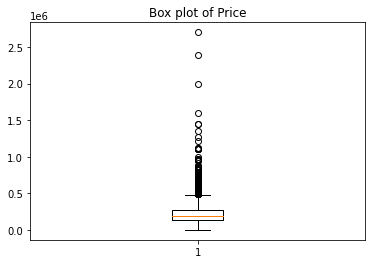

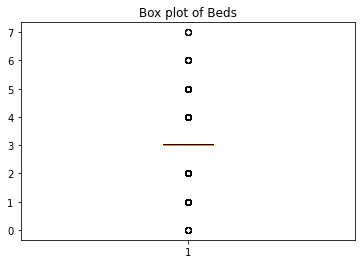

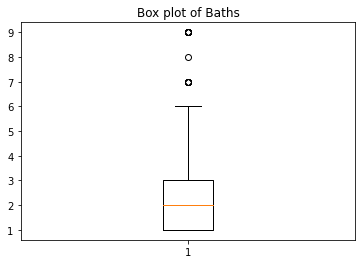

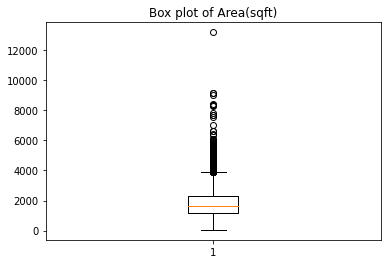

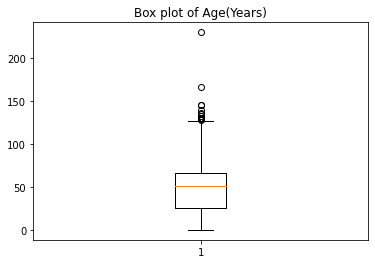

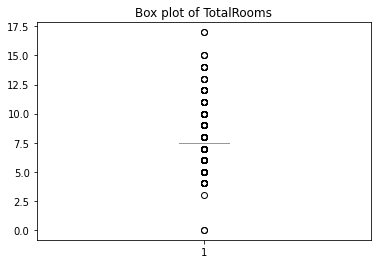

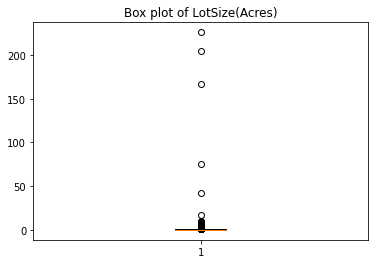

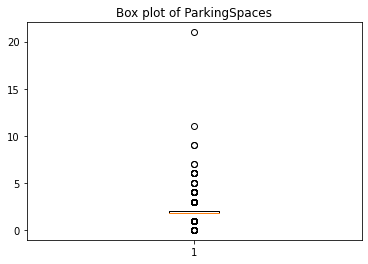

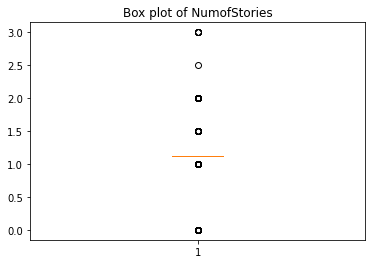

In [0]:
# Boxplot numerical columns to visualize the data for outliers

for column_name in df.columns:
    if df[column_name].dtype == 'int64' or df[column_name].dtype == 'float64':
        plt.boxplot(df[column_name])
        plt.title("Box plot of {}".format(column_name))
        plt.show()

In [0]:
# Statistically check for outliers using the Tuckey's method

for column_name in df.columns:
    if(df[column_name].dtype =='float64' or df[column_name].dtype=='int64' ):
        q75, q25 = np.percentile(df[column_name], [75 ,25])
        iqr = q75 - q25

        for threshold in np.arange(1,5):
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)
            print('\n' + column_name)
            print("The score threshold is: {}".format(threshold))
            print("Number of outliers is: {}".format(
            len((np.where((df[column_name] > max_val) 
                      | (df[column_name] < min_val))[0]))
    ))


Price
The score threshold is: 1
Number of outliers is: 281

Price
The score threshold is: 2
Number of outliers is: 124

Price
The score threshold is: 3
Number of outliers is: 50

Price
The score threshold is: 4
Number of outliers is: 32

Beds
The score threshold is: 1
Number of outliers is: 1689

Beds
The score threshold is: 2
Number of outliers is: 1689

Beds
The score threshold is: 3
Number of outliers is: 1689

Beds
The score threshold is: 4
Number of outliers is: 1689

Baths
The score threshold is: 1
Number of outliers is: 37

Baths
The score threshold is: 2
Number of outliers is: 10

Baths
The score threshold is: 3
Number of outliers is: 0

Baths
The score threshold is: 4
Number of outliers is: 0

Area(sqft)
The score threshold is: 1
Number of outliers is: 295

Area(sqft)
The score threshold is: 2
Number of outliers is: 92

Area(sqft)
The score threshold is: 3
Number of outliers is: 36

Area(sqft)
The score threshold is: 4
Number of outliers is: 15

Age(Years)
The score threshold

As anticipated earlier, Tuckey's method confirms that there are indeed some outliers in most of the columns. To deal with these outliers, dropping those observations entirely insn't appropriate in this case as I do not have a lot of data. Hence, I apply winsorization to cap off the outliers and limit their effect in the eventual model.

In [0]:
# Winsorize numerical columns to limit the effect of outliers

from scipy.stats.mstats import winsorize

for column_name in df.columns:
    if df[column_name].dtype == 'int64' or df[column_name].dtype == 'float64':
        df[column_name] = winsorize(df[column_name], (0, 0.10))

In [0]:
df.describe()

,Price,Beds,Baths,Area(sqft),Age(Years),TotalRooms,LotSize(Acres),ParkingSpaces,NumofStories
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,205395.748973,2.992852,2.062313,1793.457715,49.727060,7.332943,0.311119,1.708882,1.078915
std,98279.005397,0.754683,0.750756,723.683597,26.999300,0.504043,0.176073,0.420903,0.166842
min,750.000000,0.000000,1.000000,49.000000,0.000000,0.000000,0.010000,0.000000,0.000000
25%,134500.000000,3.000000,1.000000,1198.000000,25.000000,7.445755,0.180000,1.791554,1.114530
50%,188000.000000,3.000000,2.000000,1666.000000,51.399658,7.445755,0.250000,1.791554,1.114530
75%,274000.000000,3.043222,3.000000,2273.000000,66.000000,7.445755,0.569719,2.000000,1.114530
max,381500.000000,4.000000,3.000000,3139.000000,95.000000,7.445755,0.569719,2.000000,1.114530


From the summary, winsorization did smoothen and limit the effect of outliers. I continue to explore the data for relationships among the variables.

In [0]:
# Startiscally test for normality in the numerical variables to make sure that the variables follow a normal distribution

from scipy.stats import jarque_bera
from scipy.stats import normaltest

for column_name in df.columns:
    if(df[column_name].dtype =='float64' or df[column_name].dtype=='int64'):
        jb_stats = jarque_bera(df[column_name])
        norm_stats = normaltest(df[column_name])
        print('\n' + column_name)
        print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
        print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Price
Jarque-Bera test statistics is 155.08832849873383 and p value is 0.0
Normality test statistics is 323.85205969969195 and p value is 4.746994840783198e-71

Beds
Jarque-Bera test statistics is 208.62027821204987 and p value is 0.0
Normality test statistics is 179.48616375450231 and p value is 1.0594360619417567e-39

Baths
Jarque-Bera test statistics is 234.30828566004513 and p value is 0.0
Normality test statistics is 3692.6818836667107 and p value is 0.0

Area(sqft)
Jarque-Bera test statistics is 266.08359649035947 and p value is 0.0
Normality test statistics is 482.38876440729166 and p value is 1.7807819413368135e-105

Age(Years)
Jarque-Bera test statistics is 117.91105801572668 and p value is 0.0
Normality test statistics is 449.40119725518167 and p value is 2.5928054785414988e-98

TotalRooms
Jarque-Bera test statistics is 303458.0351197059 and p value is 0.0
Normality test statistics is 4049.4521283201675 and p value is 0.0

LotSize(Acres)
Jarque-Bera test statistics is 385.52

All the numerical variables follow the normal distribution, as such, all deductions and conclusions should meet the established assumptions. 

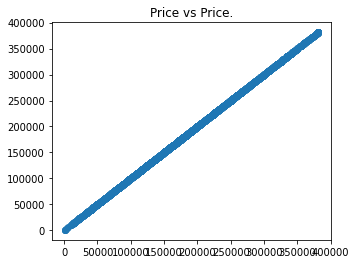

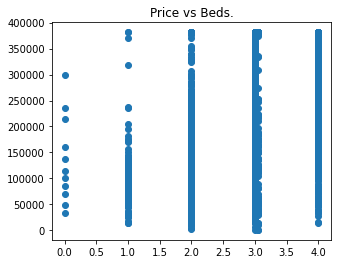

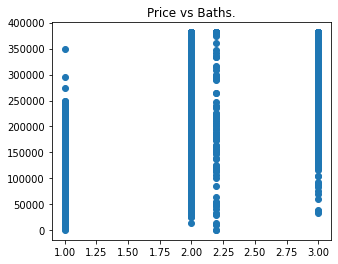

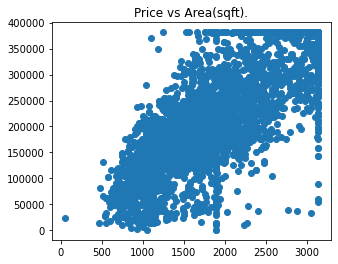

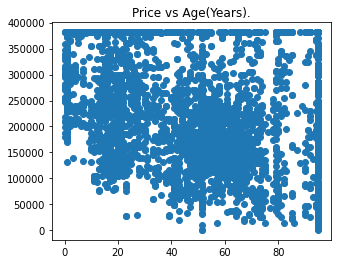

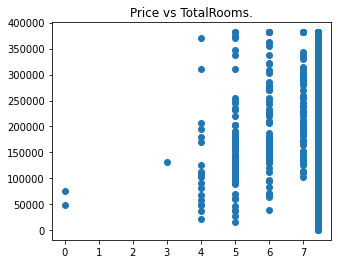

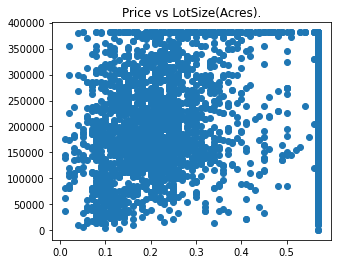

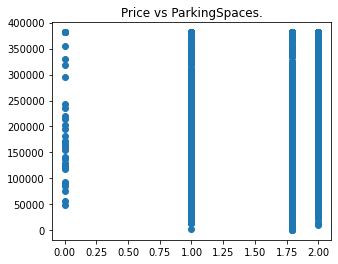

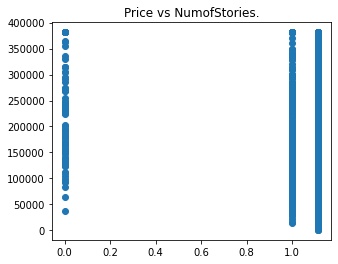

In [0]:
# Make scatter plots of the numerical variables to examine correlation

for column_name in df.columns:
    if(df[column_name].dtype =='float64' or df[column_name].dtype=='int64' ):
        plt.figure(figsize=(5,4))
        plt.scatter(df[column_name], df['Price'])
        plt.title('Price vs {}.'.format(column_name))
        
plt.show()

Some of the variables have a strong correlation with property price while others have an indeterminate correlation (judging from the visuals) with property price. To have a clearer view of correlation, I use a correlation matrix below.

In [0]:
# Get correlation matrix

for column_name in df.columns:
    if(df[column_name].dtype =='float64' or df[column_name].dtype=='int64'):
        matrix = df.corr()
        
matrix

,Price,Beds,Baths,Area(sqft),Age(Years),TotalRooms,LotSize(Acres),ParkingSpaces,NumofStories
Price,1.000000,0.514651,0.691589,0.789809,-0.336623,0.085888,0.085485,0.274006,-0.010727
Beds,0.514651,1.000000,0.457041,0.590332,-0.158090,0.091806,-0.120785,0.246636,0.002382
Baths,0.691589,0.457041,1.000000,0.737125,-0.435335,0.093670,0.111302,0.277689,0.030328
Area(sqft),0.789809,0.590332,0.737125,1.000000,-0.271488,0.122413,0.075461,0.296203,0.022623
Age(Years),-0.336623,-0.158090,-0.435335,-0.271488,1.000000,-0.033449,-0.264666,-0.230589,-0.015917
TotalRooms,0.085888,0.091806,0.093670,0.122413,-0.033449,1.000000,0.062419,0.057721,0.257223
LotSize(Acres),0.085485,-0.120785,0.111302,0.075461,-0.264666,0.062419,1.000000,0.004482,0.082107
ParkingSpaces,0.274006,0.246636,0.277689,0.296203,-0.230589,0.057721,0.004482,1.000000,-0.019827
NumofStories,-0.010727,0.002382,0.030328,0.022623,-0.015917,0.257223,0.082107,-0.019827,1.000000


In [0]:
# Check for multicollinearity

for first_column in matrix.columns:
    for second_column in matrix.columns:
        if (first_column != second_column) and (matrix[first_column][second_column] <= -0.7 or matrix[first_column][second_column] >= 0.7):
            print('{} and {} are highly correlated by {}'.format(first_column, second_column, matrix[first_column][second_column]))

Price and Area(sqft) are highly correlated by 0.7898093919776579
Baths and Area(sqft) are highly correlated by 0.7371245027983524
Area(sqft) and Price are highly correlated by 0.7898093919776579
Area(sqft) and Baths are highly correlated by 0.7371245027983524


From the correlation matrix, only Beds, Baths and Area(sqft) are correlated with property price. Perhaps, some of the other numerical variables may be strongly correlated with property price but because I have excluded all categorical variables from the analysis to this point for convinience and ease of analysis, this may be causing some of these numerical variables to not be correlated with property price as there may be the issue of ommitted variable effects.

To make an accurate determination, I'll have to include all the numerical and categorical variables in a model, then assess their correlations and effects in the model and in realtion to all the other variables. This correlation matrix is just to give an initial view into what relationships there may be among all the numerical variables and essentially their relationship with property price.

The same point applies to the issue of multicollinearity. From the correlation matrix above, it can seen that Baths and Area(sqft) are strongly correlated. However, I have ommited all the categorical variables to this point in the analysis. Hence, until all the variables and their effects are estimated in a model and in relation to one another, it is not safe to make a judgement call just yet. I, therefore, proceed to explore and analyze all the categorical variables. I analyze and do some more cleaning as and when the need arises.

In [0]:
# I begin categorical variable exploration with property type

df['Type'].value_counts()

Single Family    3120
Condominium       369
Condo              55
Townhouse           4
Multi Family        2
A                   2
Apartment           1
Name: Type, dtype: int64

From the above summary, 'Condo' and 'Condominium' are the same property types, so, I put the two together and keep the name 'Condominium' in all cases.

In [0]:
# Condo and Condominium are one and the same, put them together. All instances of Condo in the Type column will now be Condominium.
# This should increase Condominium count in the dataset.

df['Type'][df['Type'] == 'Condo'] = 'Condominium'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function seaborn.utils.despine>

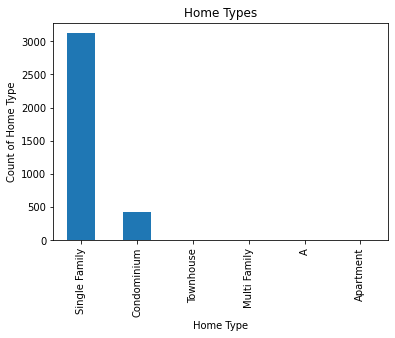

In [0]:
df['Type'].value_counts().plot(kind = 'bar')
plt.title('Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count of Home Type')
sns.despine

The most common property type is the Single family property. A great majority of the listings are single family followed by condominiums. Single Family property type may be a significant factor in determining the property value.

In [0]:
# TrimMat is exterior material used in constructing the property. This column needs some more cleaning as there are some unwanted characters

df['TrimMat'].unique()

array(['Brick&Vinyl', nan, 'Vinyl', 'Brick', 'Wood', 'Brick&Wood',
       'Brick\n', 'Vinyl&wood', 'Vinyl\n', 'Other\n', 'Vinyl&Wood',
       'Shingle\n', 'Stucco\n', 'Wood\n', 'Stone\n',
       'Brick&Stone&Vinyl&Wood', 'Brick&Stone', 'Stone', 'Other',
       'Brick&Other&Stone', 'Brick&Cement concrete', 'Brick&Shingle',
       'Other&Vinyl', 'Brick&Stone&Vinyl', 'Stone&Vinyl',
       'Brick&Vinyl&Wood', 'Stone&Wood', 'Brick&Stone&Wood',
       'Metal&Other&Wood', 'Brick&Stucco', 'Brick&Other', 'Shingle',
       'Other&Vinyl&Wood', 'Other&Stone', 'Stone&Stucco', 'Stucco&Vinyl',
       'Stone&Vinyl&Wood', 'Stucco', 'Other&Wood',
       'Brick&Other&Shingle&Vinyl', 'Brick&Other&Wood'], dtype=object)

In [0]:
# Clean up TrimMat

df['TrimMat'][df['TrimMat'] == 'Brick\n'] = 'Brick'
df['TrimMat'][df['TrimMat'] == 'Other\n'] = 'Other'
df['TrimMat'][df['TrimMat'] == 'Vinyl\n'] = 'Vinyl'
df['TrimMat'][df['TrimMat'] == 'Wood\n'] = 'Wood'
df['TrimMat'][df['TrimMat'] == 'Shingle\n'] = 'Shingle'
df['TrimMat'][df['TrimMat'] == 'Stone\n'] = 'Stone'
df['TrimMat'][df['TrimMat'] == 'Stucco\n'] = 'Stucco'
df['TrimMat'][df['TrimMat'] == 'Brick&Cement concrete'] = 'Brick&Cement&Concrete'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

<function seaborn.utils.despine>

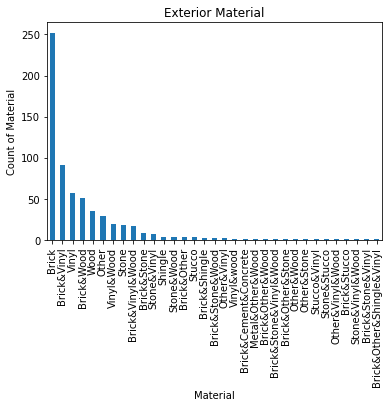

In [0]:
# Get some visuals of this column

df['TrimMat'].value_counts().plot(kind = 'bar')
plt.title('Exterior Material')
plt.xlabel('Material')
plt.ylabel('Count of Material')
sns.despine

The most common material types for property contruction is Brick or a combination of Brick and Vinyl. Following Brick and a combination of Brick&Vilny is Vinyl or Brick&Wood combination. These caterigorical factors may also be significant in determining property value.

In [0]:
# Explore the zipcode variable a little more, first get the count and print summary stats

df['zipcode'].value_counts()

40245    262
40299    209
40272    202
40229    195
40291    191
40216    190
40214    183
40220    174
40207    161
40258    145
40241    142
40219    134
40218    131
40223    126
40205    115
40206    113
40215    109
40222    107
40228    102
40204     95
40217     93
40213     85
40243     66
40242     61
40203     56
40212     49
40211     46
40208     39
40210     26
40118     16
40059      9
40202      8
40023      8
40209      3
40056      1
Name: zipcode, dtype: int64

In [0]:
# Print summary

df.groupby(['zipcode'])['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
zipcode,,,,,,,,
40023,8.0,304997.500000,104615.827913,83990.0,264250.00,346245.0,381500.00,381500.0
40056,1.0,150000.000000,NaN,150000.0,150000.00,150000.0,150000.00,150000.0
40059,9.0,292388.888889,107309.359383,152000.0,174500.00,381500.0,381500.00,381500.0
40118,16.0,108936.562500,49187.764966,30000.0,72750.00,112500.0,126725.00,197500.0
40202,8.0,314921.125000,67989.696269,195000.0,285525.00,326000.0,373076.75,381500.0
40203,56.0,159265.178571,94086.709485,6000.0,81150.00,168750.0,188125.00,381500.0
40204,95.0,221876.736842,90966.204365,63000.0,149000.00,200000.0,285750.00,381500.0
40205,115.0,278163.339130,89031.272182,74000.0,217500.00,283000.0,370000.00,381500.0
40206,113.0,233543.619469,108129.073652,55000.0,132000.00,225000.0,342940.00,381500.0


The zipcode with the most listings is 40245 followed by 40299. These zipcodes may carry some significance in determining property prices.

At this point, the rest of the variables are binary categorical variables and I proceed by separating those variables and subsequently hot encoding them for model buidling.

In [0]:
# Hot encode categorical variables and drop first

df = pd.concat([df, pd.get_dummies(df['zipcode'], prefix= 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['Type'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasGarage'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['TrimMat'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasBasement'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasPatio'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasPorch'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasDeck'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasLawn'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasPool'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasGarden'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasFireplace'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['CableReady'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasSecuritySystem'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasTennisCourt'], prefix = 1, drop_first = True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['HasIntercom'], prefix = 1, drop_first = True)], axis=1)

In [0]:
# Make a list of all categorical variables in the dataset

lst = []
for column_name in df.columns:
    if df[column_name].dtype == 'object':
        lst.append(column_name)

In [0]:
# Now that all categorical variables have been hot encoded, I remove those variables from the dataset and keep only their hot encoded versions.
#  The resultant dataset is now ready for building machine learning models.

df = df.drop(lst, axis = 1)

In [0]:
df.head()

,Price,Beds,Baths,Area(sqft),Age(Years),TotalRooms,LotSize(Acres),ParkingSpaces,NumofStories,1_40056,1_40059,1_40118,1_40202,1_40203,1_40204,1_40205,1_40206,1_40207,1_40208,1_40209,1_40210,1_40211,1_40212,1_40213,1_40214,1_40215,1_40216,1_40217,1_40218,1_40219,1_40220,1_40222,1_40223,1_40228,1_40229,1_40241,1_40242,1_40243,1_40245,1_40258,1_40272,1_40291,1_40299,1_Apartment,1_Condominium,1_Multi Family,1_Single Family,1_Townhouse,1_Garage,1_Brick&Cement&Concrete,1_Brick&Other,1_Brick&Other&Shingle&Vinyl,1_Brick&Other&Stone,1_Brick&Other&Wood,1_Brick&Shingle,1_Brick&Stone,1_Brick&Stone&Vinyl,1_Brick&Stone&Vinyl&Wood,1_Brick&Stone&Wood,1_Brick&Stucco,1_Brick&Vinyl,1_Brick&Vinyl&Wood,1_Brick&Wood,1_Metal&Other&Wood,1_Other,1_Other&Stone,1_Other&Vinyl,1_Other&Vinyl&Wood,1_Other&Wood,1_Shingle,1_Stone,1_Stone&Stucco,1_Stone&Vinyl,1_Stone&Vinyl&Wood,1_Stone&Wood,1_Stucco,1_Stucco&Vinyl,1_Vinyl,1_Vinyl&Wood,1_Vinyl&wood,1_Wood,1_Basement,1_Patio,1_Porch,1_ Deck,1_Deck,1_Lawn,1_Pool,1_Garden,1_Fireplace,1_Cable Ready,1_Security System,1_Tennis Court,1_Intercom
0,295500,2.0,1.0,1696.0,35.0,7.000000,0.300000,0.0,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,170900,1.0,1.0,1058.0,42.0,7.445755,0.569719,0.0,1.11453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
2,236000,1.0,1.0,1734.0,95.0,7.445755,0.569719,0.0,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,381500,3.0,2.0,2835.0,21.0,5.000000,0.360000,0.0,1.11453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
4,354500,2.0,2.0,2310.0,30.0,7.445755,0.569719,0.0,1.11453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


The dataset is now ready for modeling at this stage. Since, this is a regression problem, I will apply linear regression to model the data. In order that I can assess the statistical significance and effect of each variable in the model, I will apply linear regression from stats model. This way, I will obtain p-values with which I can assess each variable's effect on property price. I proceed here to define my target variable and features. 

The target variable here is the property price and all the other variables are the features. My approach here goes like this: I estimate a general model first and foremost so I can make a determination with p-values about which variables are significant in determing the property price. Subsequently, I split up the data into a train and test set; I then train a model on the train set. The model will be tested on the test set. Also, model performance will be assessed based on the learning model.

In [0]:
# Declare features and target

X = df.drop('Price', axis = 1)
Y = df['Price']

In [0]:
# Estimate a general model to begin with

import statsmodels.api as sm

# Introduce a constant into the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     182.9
Date:                Mon, 25 May 2020   Prob (F-statistic):               0.00
Time:                        14:12:01   Log-Likelihood:                -44057.
No. Observations:                3653   AIC:                         8.829e+04
Df Residuals:                    3564   BIC:                         8.884e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

From the general model and based on p-values at 5% significance level (ie. p-value <= 0.05), the following numerical variables are significant determinants of prroperty price: Beds (p-value = 0.000), Baths (p-value = 0.000), Area(p-value = 0.000), Age (p-value = 0.000), Lot Size (p-value = 0.001), Parking spaces (p-value = 0.000), Condominium (p-value = 0.000), Single Family (p-value = 0.000).

Number of Beds, number of Baths, the property square Area, Lot Size of property and the number of parking spaces all have a positive effect on property price so that the more beds, the more baths, the larger the square area, the larger the lot size or the more parking spaces of a property, the higher the price. Age, on the other hand, has a negative effect on property price, in that, the older the property, the lower the price thereby lowering the value of the property.

With regards categorical variables, whether a property has a garage or not ie. the 'HasGarage' variable is significant at the 5% level with a p-value of 0.000.
Within the property type category, Condominium and Single Family types are significant at the 5% level with a p=values of 0.000.

Regarding zipcodes, there may be the issue of ommited variables, insufficient observations or outlier issues behind the insignificance of some zipcodes. Out of 35 distinct zipcodes, about 20 of them are significant at the 5% level. Given that majority of the zipcodes are significant, I conclude that the zipcode of a particular property is a significant factor in determining the propety price. The relationship between zipcode and property price varies with the zipcode so that property value decreases or increases depending on the zipcode within which a property is located.

All the other numerical and categorical variables are insignificant in determining the price of property. Hence, the model specification is as follows:
**Property Value = 72830 + 9340Beds + 14340Baths + 59Area(sqft) - 465Age(Years) + 15910LotSize(Acres) + 6511ParkingSpaces (+/-)appropriate zipcode estimate - 26100Condominium - 17960Single Family + 11460HasGarage.**

Now, I turn attention to making predictions with the model. To acomplish this, I split the dataset into train and test sets. I train the model on the train set and test it on the test set, the aim here is to check how well the model does when supplied new data.

In [0]:
# Split up the data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)

In [0]:
# Now, train the model using train set

# Add a constant into the model
X_train = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     152.3
Date:                Mon, 25 May 2020   Prob (F-statistic):               0.00
Time:                        14:12:01   Log-Likelihood:                -35267.
No. Observations:                2922   AIC:                         7.070e+04
Df Residuals:                    2838   BIC:                         7.120e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [0]:
# Add a constant into the test set and use it to predict property prices.
# I then check the accuracy of predictions by plotting the predicted values against the actual values to examine accuracy
X_test = sm.add_constant(X_test)

# Predict prices
y_preds = model.predict(X_test)

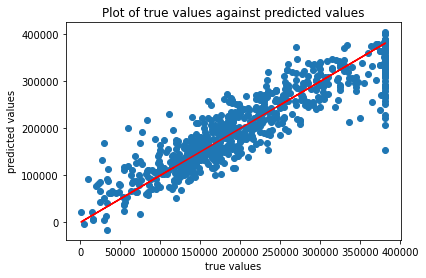

In [0]:
# Visualize predictions and actual values


plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color = "red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Plot of true values against predicted values")
plt.show()

From this visualization, it can be seen that property values on the higher end and some few on the lower end are not being fitted perfectly. That aside, the model is predicting property values quite well. Instances where the predicted values are a little far from the true values may be due to the extreme nature of those values and the model tries to limit the effect of those extreme values owing to winsorization (winsorization was applied to deal with outliers). 

Additionally, the model may be suffering from the issue of ommitted variable effects as the data may be lacking in certain essential information/data given that not all information is provided or even available for all properties during their listing on websites. All these drawbacks notwithstanding, the model is doing quiet well predicting property values.

For the avoidance of doubt, I train another model this time using a linear regression to check for any issues of overfitting as the stats model is incapable of checking same. 

In [0]:
from sklearn.linear_model import LinearRegression

# Fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-1.83730952e-09  8.95441584e+03  1.48273863e+04  5.90474622e+01
 -4.70429052e+02  1.22720997e+03  1.10837835e+04  6.73029479e+03
 -1.20723416e+04 -4.42887540e-08 -1.55255280e+03 -6.86904001e+04
  1.28826254e+05 -5.91687884e+04  2.20414734e+04  3.92234933e+04
  1.48521967e+04  4.10856251e+04 -7.86878166e+04 -7.62202366e+04
 -1.29367489e+05 -1.33868101e+05 -1.45866342e+05 -5.49641781e+04
 -6.71875681e+04 -9.34145980e+04 -8.65504057e+04 -6.03660526e+03
 -5.91329521e+04 -6.84653578e+04 -3.28603494e+04  3.97147784e+02
 -7.83181418e+03 -4.83545029e+04 -5.77542083e+04 -4.21944653e+03
 -2.15220792e+04 -8.86089049e+03  1.10327285e+04 -7.38144644e+04
 -7.19861770e+04 -3.85301572e+04 -2.87164854e+04 -2.72283319e+04
 -1.95315854e+04 -4.95944147e+04  2.26177537e+04  1.21201939e+04
  1.16397515e+04  1.42321858e+04 -3.38932437e+04  0.00000000e+00
 -9.42411705e+03  3.27418093e-11 -1.12164965e+03  2.33962231e+04
  1.49906976e+04  4.27097253e+04  3.01988949e+04 -5.90220624e+04
  6.1570

In [0]:
# Make predictions and check accuracy on train and test sets
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

In [0]:
print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))

R-squared of the model in the training set is: 0.8166472097733881
R-squared of the model in the test set is: 0.8174609243319373


From the R-squared scores of the train and test sets, I conclude that the model is not overfitting. In fact, the model is learning quite very well and predicting property values to a good degree of accuracy.

**Conclusion**

Real estate purchase decisions can be dicey because of the wide range of property values and also because of the many factors that influence property values. As such, a model that can estimate well the value of real estate will be a great tool in making property purchase decisions. The model as specified above is designed to help in valuing real estate property in the face of the most current market conditions in the Louisville metro area. 

The model can be coded into real estate property investment company website/mobile app, where investors can use it to estimate the value of properties they are interested in, so they can make data supported buying decisions. The model can also be coded into property purchasing apps or websites to be used as a property value estimator by property buyers to guide their purchase decisions.